D/D/1: deterministic interarrival/deterministic service/one server
Initial jobs:

    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time


id,T,A,S,W,E
0,1.000000,1.000000,0.666667,0.000000,1.666667
1,1.000000,2.000000,0.666667,0.000000,2.666667
2,1.000000,3.000000,0.666667,0.000000,3.666667
3,1.000000,4.000000,0.666667,0.000000,4.666667
4,1.000000,5.000000,0.666667,0.000000,5.666667


label,def,stat_sim,stat_ana
lambda,mean arrival rate,1.000000,1
mu,mean service rate,1.500000,1.500000
rho,(mean arrival rate)/(mean service rate),0.666667,0.666667
sigma^2,variance of the service dist. G,0.000000,0
p_N_s,prob. of having N jobs in the system,[0.311 0.689],[0.333 0.667]
p_N_q,prob. of having N jobs in the queue,[1.],[1]
p_0_s,prob. of having 0 jobs in the system,0.311000,0.333333
p_0_q,prob. of having 0 jobs in the queue,1.000000,1
L_s,expected number of jobs in the system,0.689400,0.666667
L_q,expected number of jobs in the queue,0.000000,0


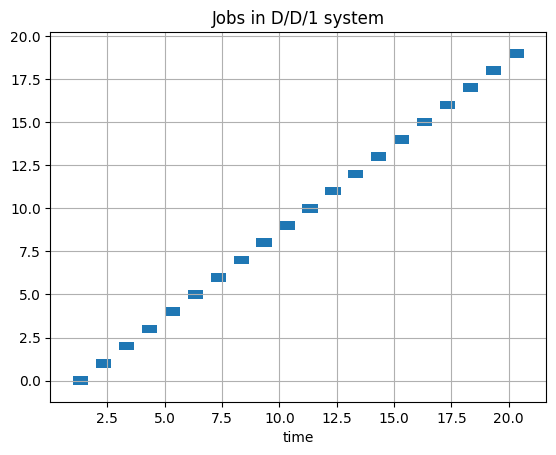

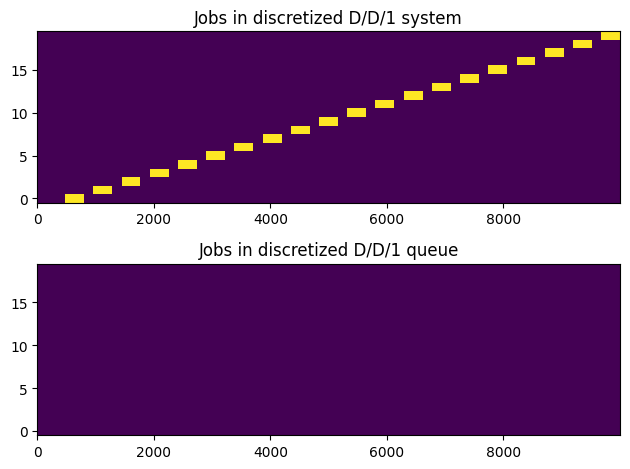

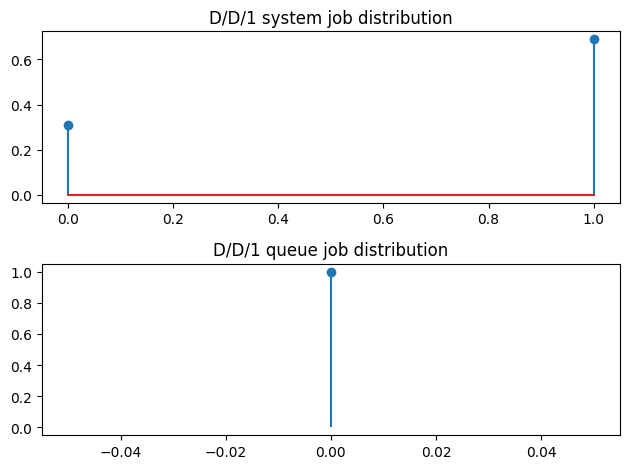

M/D/1: exponential interarrival/deterministic service/one server
Initial jobs:

    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time


id,T,A,S,W,E
0,0.795875,0.795875,0.666667,0.000000,1.462541
1,1.255931,2.051805,0.666667,0.000000,2.718472
2,0.923223,2.975028,0.666667,0.000000,3.641695
3,0.787201,3.762230,0.666667,0.000000,4.428896
4,0.551048,4.313278,0.666667,0.115618,5.095563


label,def,stat_sim,stat_ana
lambda,mean arrival rate,1.001408,1.000000
mu,mean service rate,1.500000,1.500000
rho,(mean arrival rate)/(mean service rate),0.667605,0.666667
sigma^2,variance of the service dist. G,0.000000,0.000000
p_N_s,prob. of having N jobs in the system,[0.33 0.318 0.18 0.091 0.045 0.021 0.008 0.004 0.002 0.001 0. 0. 0. 0. 0. 0. ],nan
p_N_q,prob. of having N jobs in the queue,[0.647 0.18 0.091 0.045 0.021 0.008 0.004 0.002 0.001 0. 0. 0. 0. 0. 0. ],nan
p_0_s,prob. of having 0 jobs in the system,0.330000,nan
p_0_q,prob. of having 0 jobs in the queue,0.647000,nan
L_s,expected number of jobs in the system,1.346100,1.333333
L_q,expected number of jobs in the queue,0.675600,0.666667


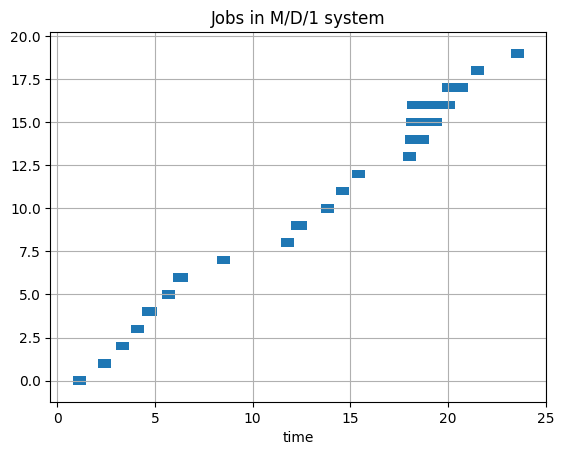

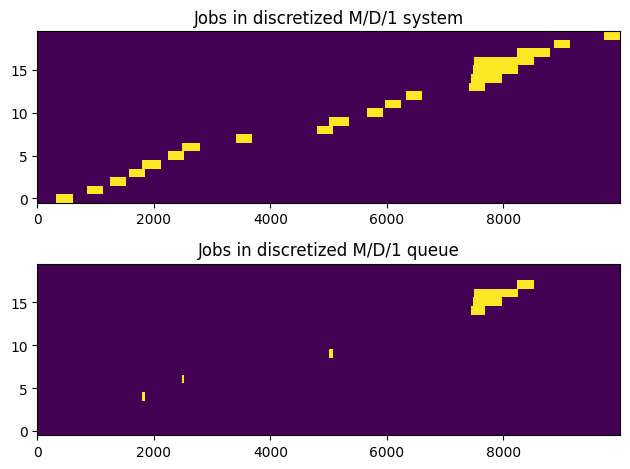

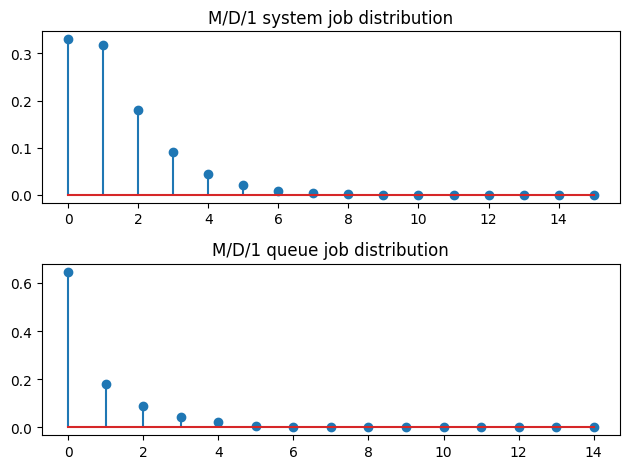

M/M/1: exponential interarrival/exponential service/one server
Initial jobs:

    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time


id,T,A,S,W,E
0,0.212110,0.212110,0.153505,0.000000,0.365614
1,0.060332,0.272441,1.966660,0.093173,2.332274
2,0.574139,0.846580,0.068410,1.485694,2.400684
3,1.274026,2.120606,0.848464,0.280078,3.249148
4,1.739613,3.860219,1.226519,0.000000,5.086738


label,def,stat_sim,stat_ana
lambda,mean arrival rate,0.995039,1
mu,mean service rate,1.505241,1.500000
rho,(mean arrival rate)/(mean service rate),0.661050,0.666667
sigma^2,variance of the service dist. G,0.446146,0.444444
p_N_s,prob. of having N jobs in the system,[0.338 0.233 0.145 0.097 0.059 0.046 0.026 0.019 0.012 0.009 0.006 0.003 0.002 0.001 0.001 0. 0. 0. 0. 0. 0. ],[0.333 0.222 0.148 0.099]
p_N_q,prob. of having N jobs in the queue,[0.571 0.145 0.097 0.059 0.046 0.026 0.019 0.012 0.009 0.006 0.003 0.002 0.001 0.001 0. 0. 0. 0. 0. 0. ],nan
p_0_s,prob. of having 0 jobs in the system,0.338000,0.333333
p_0_q,prob. of having 0 jobs in the queue,0.571000,nan
L_s,expected number of jobs in the system,1.932200,2.000000
L_q,expected number of jobs in the queue,1.270000,1.333333


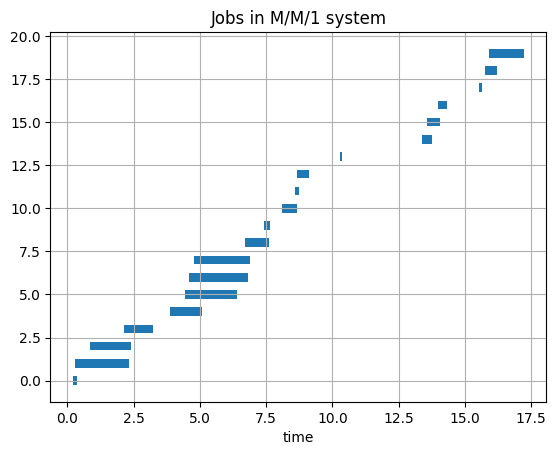

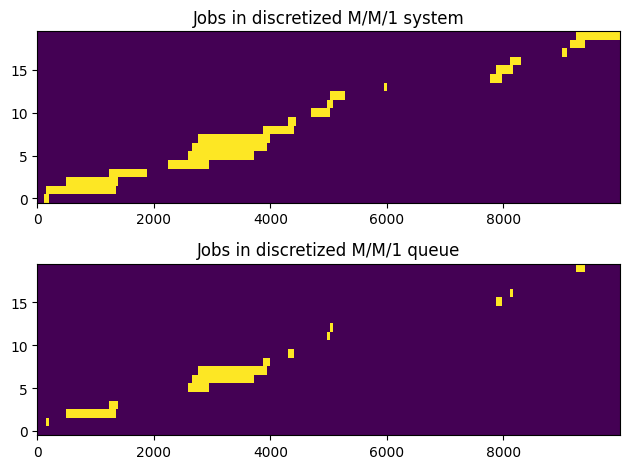

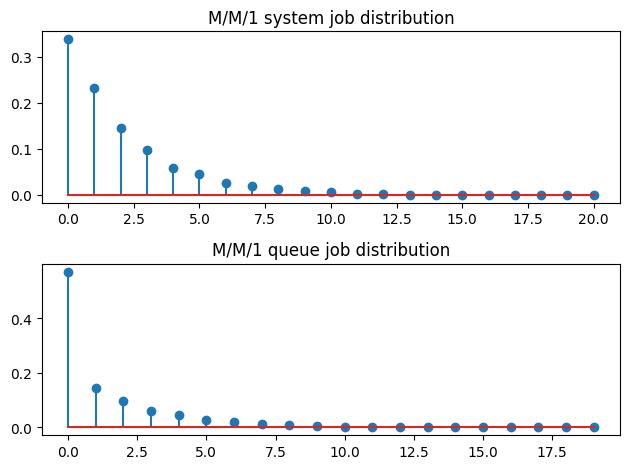

M/G/1 (G=Uniform): exponential interarrival/uniform service/one server
Initial jobs:

    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time


id,T,A,S,W,E
0,3.393308,3.393308,1.225983,0.000000,4.619291
1,3.673071,7.066380,1.173061,0.000000,8.239440
2,0.139742,7.206122,1.057084,1.033318,9.296524
3,0.713618,7.919741,0.232364,1.376784,9.528888
4,0.120858,8.040599,0.961064,1.488290,10.489952


label,def,stat_sim,stat_ana
lambda,mean arrival rate,1.002423,1.000000
mu,mean service rate,1.500944,1.500000
rho,(mean arrival rate)/(mean service rate),0.667862,0.666667
sigma^2,variance of the service dist. G,0.147994,0.148148
p_N_s,prob. of having N jobs in the system,[0.335 0.26 0.178 0.105 0.051 0.031 0.018 0.009 0.006 0.003 0.002 0.001 0.001 0. 0. 0. 0. 0. 0. 0. ],nan
p_N_q,prob. of having N jobs in the queue,[0.595 0.178 0.105 0.051 0.031 0.018 0.009 0.006 0.003 0.002 0.001 0.001 0. 0. 0. 0. 0. 0. 0. ],nan
p_0_s,prob. of having 0 jobs in the system,0.335000,nan
p_0_q,prob. of having 0 jobs in the queue,0.595000,nan
L_s,expected number of jobs in the system,1.580000,1.555556
L_q,expected number of jobs in the queue,0.915300,0.888889


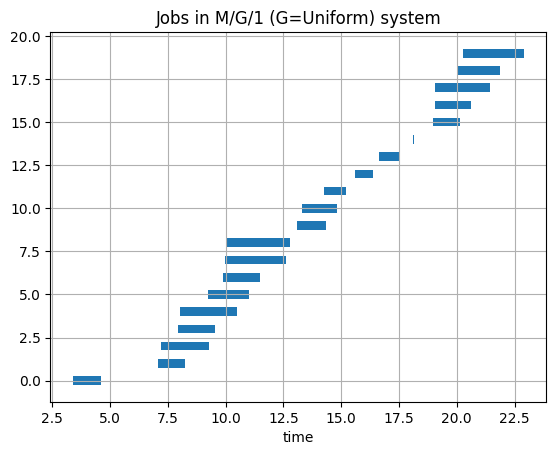

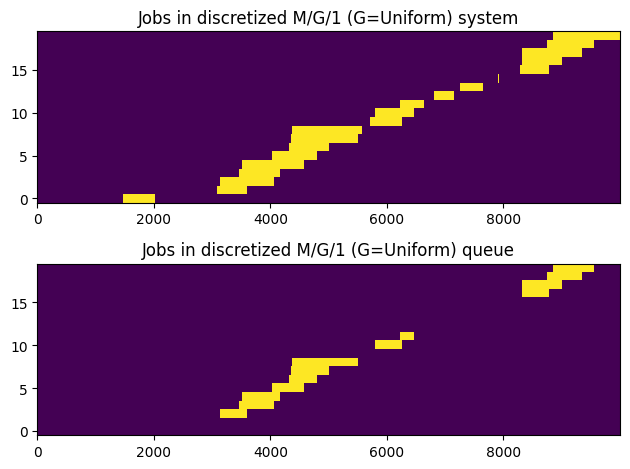

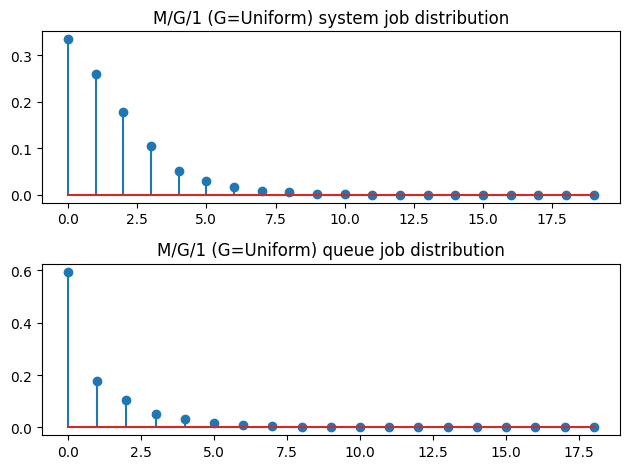

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import exponential, uniform, poisson
import pandas as pd
import scipy
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

N_DIGITS = 3   # rounding
N_DIST = 4 # number of distribution values to show

def make_job_table(T, S):
    '''Construct a table (DataFrame) of job data,
    given interarrival times T and service times S
    (each length-n vectors).
    
    We want to see the following for each job:
    
    id: job ID (from 0 to n-1)
    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time'''
    assert(len(T) == len(S))
    n = len(T)
    job_ids = np.arange(n)
    # arrival times
    A = np.cumsum(T)
    # waiting times (to be filled in)
    W = np.zeros(n)
    # exit times (to be filled in):
    E = np.zeros(n)
    # the job exits after
    # it arrived, waited (maybe), and got served
    E[0] = A[0] + W[0] + S[0]
    for i in range(1, n):
        if A[i] > E[i-1]:
            # then this job arrived
            # after the previous job finished,
            # so there's no wait
            W[i] = 0
        else:
            # then this job will have to wait
            # until the previous job finishes
            W[i] = E[i-1] - A[i]
        E[i] = A[i] + W[i] + S[i]

    d = {
        'id': job_ids,
        'T': T,
        'A': A,
        'S': S,
        'W': W,
        'E': E
    }

    df_jobs = pd.DataFrame(d)
    return df_jobs

def job_table_to_stats(df_jobs, nt=10000):
    '''Construct a table of system and queue statistics.
    "System" statistics includes the service time,
    while "queue" statistics do not.
    
    df_jobs: a table generated by make_job_table()
    nt: number of time steps
    '''
    
    # grab job data from the table
    job_ids, T, A, S, W, E = df_jobs.to_numpy().T
    
    n, ncols = df_jobs.shape
    
    # make a time grid
    t_max = df_jobs['E'].iloc[-1]  # the last exit time
    nt = 10000                     # number of time slices
    t = np.linspace(0, t_max, nt)

    # construct matrices indicating whether
    # each job j is in the system/queue or not at time t[i], i.e.
    # system_mat = [1 if job j is in the system at time t[i], else 0],
    # queue_mat = [1 if job j is in the queue at time t[i], else 0],
    system_mat = np.zeros((nt, n))
    queue_mat = np.zeros((nt, n))
    for j in job_ids.astype('int'):
        # for the system matrix,
        # just check if t is between job j's arrival and exit times
        system_mat[:, j] = np.where((A[j] <= t) & (t < E[j]), 1, 0)
        # similarly for the queue matrix, but don't count the service time
        queue_mat[:, j] = np.where((A[j] <= t) & (t < E[j] - S[j]), 1, 0)

    # gather statistics:
    lamb = 1/np.mean(T) # mean arrival rate
    mu = 1/np.mean(S)   # mean service rate
    rho = lamb/mu
    s2 = np.var(S)    # variance of service rate

    # probability of having N jobs in the system/queue (distributions):
    n_jobs_s = np.sum(system_mat, axis=1).astype('int')
    n_jobs_q = np.sum(queue_mat, axis=1).astype('int')
    # count bins and normalize by the number of time steps
    p_N_s = (np.bincount(n_jobs_s) / nt).round(N_DIGITS)
    p_N_q = (np.bincount(n_jobs_q) / nt).round(N_DIGITS)

    # probability of having zero jobs in the system/queue
    p_0_s = p_N_s[0]
    p_0_q = p_N_q[0]

    # mean number of jobs in the system/queue
    L_s = np.mean(n_jobs_s)
    L_q = np.mean(n_jobs_q)

    # mean time in the system/queue
    W_s = np.mean(W + S)
    W_q = np.mean(W)

    labels = ['lambda', 'mu', 'rho', 'sigma^2', 'p_N_s', 'p_N_q', 'p_0_s', 'p_0_q', 'L_s', 'L_q', 'W_s', 'W_q']
    stats  = [ lamb,     mu,   rho,         s2,  p_N_s,   p_N_q,   p_0_s,   p_0_q,   L_s,   L_q,   W_s,   W_q]
    defs = [
        'mean arrival rate',
        'mean service rate',
        '(mean arrival rate)/(mean service rate)',
        'variance of the service dist. G',
        'prob. of having N jobs in the system',
        'prob. of having N jobs in the queue',
        'prob. of having 0 jobs in the system',
        'prob. of having 0 jobs in the queue',
        'expected number of jobs in the system',
        'expected number of jobs in the queue',
        'expected time spent in the system',
        'expected time spent in the queue',
    ]

    d = {
        'label': labels,
        'def': defs,
        'stat_sim': stats
    }
    df_stats = pd.DataFrame(d)

    return (df_stats, system_mat, queue_mat)

def plot_jobs(df_jobs, title, ax):
    job_ids, T, A, S, W, E = df_jobs.to_numpy().T
    for job_id, A_i, E_i in zip(job_ids, A, E):
        ax.broken_barh([(A_i, E_i-A_i)], (job_id-0.25, 0.5))
    ax.set_xlabel('time')
    ax.grid(True)
    ax.set_title(title)
    plt.show()

def plot_time_slices(time_slice_mat, title, ax):
    '''Plot a matrix of time slices.
    System matrix plots should look similar to the job plot,
    but with a different time scale.
    Queue matrix plots should have shorter bars
    (or missing bars, in the case of no wait),
    because the service times don't count.'''
    ax.imshow(time_slice_mat.T, origin='lower', interpolation='none', aspect='auto')
    ax.set_title(title)

def plot_distribution(p_N, title, ax):
    ax.stem(p_N)
    ax.set_title(title)

def D_D_1_analytic(lamb, mu):
    # from "Auditing of Queueing Systems under Various Frame-Works"
    rho = lamb/mu
    sigma2 = 0
    p_0_s = 1 - rho
    p_N_s = (
        np.array([1 - rho, rho])
    ).round(N_DIGITS)
    p_0_q = 1
    p_N_q = np.array([1])
    L_s = rho
    L_q = 0
    W_s = 1/mu
    W_q = 0
    labels = ['lambda', 'mu', 'rho', 'sigma^2', 'p_N_s', 'p_0_s', 'L_s', 'L_q', 'W_s', 'W_q', 'p_0_q', 'p_N_q']
    stats = [    lamb,   mu ,  rho ,  sigma2 ,  p_N_s ,  p_0_s ,  L_s ,  L_q ,  W_s ,  W_q ,  p_0_q ,  p_N_q ]
    d = {
        'label': labels,
        'stat_ana': stats
    }
    df_ana = pd.DataFrame(d)
    return df_ana

def M_D_1_analytic(lamb, mu):
    # from "Auditing of Queueing Systems under Various Frame-Works"
    rho = lamb/mu
    sigma2 = 0
    L_s = rho*(2-rho)/(2*(1-rho))
    L_q = rho**2/(2*(1-rho))
    W_s = (2-rho)/(2*mu*(1-rho))
    W_q = rho/(2*mu*(1-rho))
    labels = ['lambda', 'mu', 'rho', 'sigma^2', 'L_s', 'L_q', 'W_s', 'W_q']
    stats = [    lamb,   mu ,  rho ,  sigma2 ,   L_s ,  L_q ,  W_s ,  W_q ]
    d = {
        'label': labels,
        'stat_ana': stats
    }
    df_ana = pd.DataFrame(d)
    return df_ana



def M_M_1_analytic(lamb, mu):
    # from "Auditing of Queueing Systems under Various Frame-Works"
    rho = lamb/mu
    sigma2 = 1/mu**2
    p_0_s = 1 - rho
    p_N_s = (
        (1-rho)*rho**(np.arange(N_DIST))
    ).round(N_DIGITS)
    L_s = rho/(1-rho)        # = lamb / (mu-lamb)
    L_q = rho**2/(1-rho)     # = lamb**2 / (mu*(mu-lamb))
    W_s = rho/(lamb*(1-rho)) # = 1 / (mu-lamb)
    W_q = rho/(mu*(1-rho))   # = lamb / (mu*(mu-lamb))
    labels = ['lambda', 'mu', 'rho', 'sigma^2', 'p_N_s', 'p_0_s', 'L_s', 'L_q', 'W_s', 'W_q']
    stats = [    lamb,   mu ,  rho ,  sigma2 ,  p_N_s ,  p_0_s ,  L_s ,  L_q ,  W_s ,  W_q ]

    d = {
        'label': labels,
        'stat_ana': stats
    }
    df_ana = pd.DataFrame(d)
    return df_ana

def M_G_1_analytic(lamb, mu, sigma2):
    # from "Auditing of Queueing Systems under Various Frame-Works"
    rho = lamb/mu
    L_s = (rho**2 + lamb**2*sigma2)/(2*(1-rho)) + rho
    L_q = (rho**2 + lamb**2*sigma2)/(2*(1-rho))
    W_s = (rho**2/lamb + lamb*sigma2)/(2*(1-rho)) + 1/mu
    W_q = (rho**2/lamb + lamb*sigma2)/(2*(1-rho))
    labels = ['lambda', 'mu', 'rho', 'sigma^2', 'L_s', 'L_q', 'W_s', 'W_q']
    stats = [    lamb,   mu ,  rho ,  sigma2 ,  L_s ,  L_q ,  W_s ,  W_q ]
    d = {
        'label': labels,
        'stat_ana': stats
    }
    df_ana = pd.DataFrame(d)
    return df_ana

def queue_demo(label, T, S, df_ana):
    # tables
    df_jobs = make_job_table(T, S)
    df_stats, system_mat, queue_mat = job_table_to_stats(df_jobs)
    df_all = df_stats.merge(df_ana, 'outer', on='label')
    print('Initial jobs:')
    print('''
    T: interarrival time
    A: arrival time
    S: service time
    W: waiting time
    E: exit time''')
    display(
        df_jobs
        .head(5)
        .style.hide(axis='index')
    )    
    display(
        df_all
        .style.hide(axis='index')
    )
    
    # plots:
    # jobs
    fig, ax = plt.subplots()
    max_jobs = 20
    df_jobs_head = df_jobs.head(max_jobs)
    plot_jobs(df_jobs_head, f'Jobs in {label} system', ax)
    plt.show()
    
    # jobs and wait times
    fig, axs = plt.subplots(2, 1)
    df_stats_head, system_mat_head, queue_mat_head = job_table_to_stats(df_jobs_head)
    plot_time_slices(system_mat_head, f'Jobs in discretized {label} system', axs[0])
    plot_time_slices(queue_mat_head, f'Jobs in discretized {label} queue', axs[1])
    plt.tight_layout()
    plt.show()
    
    # number of jobs in system/queue distributions
    fig, axs = plt.subplots(2, 1)
    plot_distribution(
        df_stats[df_stats['label'] == 'p_N_s']['stat_sim'].iloc[-1],
        f'{label} system job distribution',
        axs[0]
    )
    plot_distribution(
        df_stats[df_stats['label'] == 'p_N_q']['stat_sim'].iloc[-1],
        f'{label} queue job distribution',
        axs[1])
    plt.tight_layout()
    plt.show()
    
def all_queue_demos():
    np.random.seed(0)
    n = 90000
    lamb = 1
    mu = 1.5
    labels = [
        'D/D/1',
        'M/D/1',
        'M/M/1',
        'M/G/1 (G=Uniform)'
    ]
    long_labels = [
        'deterministic interarrival/deterministic service/one server',
        'exponential interarrival/deterministic service/one server',
        'exponential interarrival/exponential service/one server',
        'exponential interarrival/uniform service/one server'
    ]
    T = [
        np.ones(n) / lamb,
        exponential(scale=1/lamb, size=n),
        exponential(scale=1/lamb, size=n),
        exponential(scale=1/lamb, size=n)
    ]
    S = [
        np.ones(n) / mu,
        np.ones(n) / mu,
        exponential(scale=1/mu, size=n),
        uniform(low=0, high=2/mu, size=n)
    ]
    
    df_ana = [
        D_D_1_analytic(lamb, mu),
        M_D_1_analytic(lamb, mu),
        M_M_1_analytic(lamb, mu),
        M_G_1_analytic(lamb, mu, (2/mu)**2/12)
    ]
    for label, long_label, T_i, S_i, df_ana_i in zip(labels, long_labels, T, S, df_ana):
        print(f'{label}: {long_label}')
        queue_demo(label, T_i, S_i, df_ana_i)

all_queue_demos()